In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gpplot.set_aesthetics(context = 'paper')

In [3]:
lognorms = pd.read_table('../data/raw/lognorm-FASN_MOLM13_NOMO-1_AKS_ALG_v2.txt')
library_df = pd.read_csv('../data/raw/Cas12_FASN_GI_12k_library.csv')

### pDNA filtering

/Users/pdeweird/.local/share/virtualenvs/hart_lipid_metabolism-R5k7HHRA/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


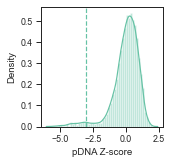

In [4]:
pdna = lognorms[['Construct IDs', 'pDNA;FASN;RDA_052;;;;']].copy()
pdna['pdna_z'] = (pdna['pDNA;FASN;RDA_052;;;;'] - pdna['pDNA;FASN;RDA_052;;;;'].mean())/pdna['pDNA;FASN;RDA_052;;;;'].std()
fig, ax = plt.subplots(figsize=(2.2,2.2))
sns.distplot(pdna['pdna_z'])
plt.axvline(x = -3, linestyle = 'dashed')
plt.xlabel('pDNA Z-score')
gpplot.savefig('../figures/pdna_filter.pdf')

In [5]:
filtered_pdna = pdna.loc[pdna['pdna_z'].abs() < 3, ['Construct IDs', 'pDNA;FASN;RDA_052;;;;']]

In [6]:
print('filtered ' + str(pdna.shape[0] - filtered_pdna.shape[0]) + ' guides due to low pDNA abundance')

filtered 336 guides due to low pDNA abundance


### Calculating log-fold changes

In [7]:
filtered_lognorms = lognorms.merge(filtered_pdna, how='inner', on=['Construct IDs', 'pDNA;FASN;RDA_052;;;;'])
long_lognorms = (filtered_lognorms
                 .drop(';;;;;;', axis=1)
                 .melt(id_vars = ['Construct Barcode', 'Construct IDs', 'pDNA;FASN;RDA_052;;;;'], 
                       var_name = 'condition', value_name = 'lognorm'))
long_lognorms['lfc'] = long_lognorms['lognorm'] - long_lognorms['pDNA;FASN;RDA_052;;;;']

### Joinging log-fold changes

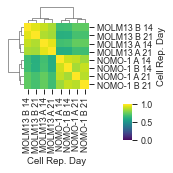

In [33]:
long_lognorms[['cell', 'library', 'rda', 'rep', 'day', 'treatment']] = long_lognorms.condition.str.split(';', n=5, expand=True)
long_lognorms[['Cell Rep. Day']] = long_lognorms['cell'] + ' ' + long_lognorms['rep'] + ' ' + long_lognorms['day']
pivoted_lfcs = long_lognorms.pivot(index='Construct IDs', columns = 'Cell Rep. Day', values = 'lfc')
cor_mat = pivoted_lfcs.corr()
ax = sns.clustermap(cor_mat, cmap = gpplot.style.sequential_cmap(), figsize=(2.5, 2.5), vmin=0, vmax=1, 
                    cbar_pos=(0.7, 0.2, 0.05, 0.2))
gpplot.savefig('../figures/correlation_heatpmap.pdf')


In [9]:
avg_lfcs = (long_lognorms.groupby(['Construct IDs', 'cell', 'library','day'])
            .agg({'lfc': 'mean'})
            .reset_index())
avg_lfcs['condition'] = avg_lfcs['cell'] + '_' + avg_lfcs['day']
avg_lfcs = avg_lfcs.drop(['cell', 'library', 'day'], axis=1)
avg_lfcs[['gene_pair', 'sequence']] = avg_lfcs['Construct IDs'].str.split(';', expand=True)
avg_lfcs[['gene1', 'gene2']] = avg_lfcs.gene_pair.str.split(':', expand=True)
avg_lfcs[['guide1', 'DR', 'guide2']] = avg_lfcs.sequence.str.split(':', expand=True)
avg_lfcs = avg_lfcs.drop(['DR', 'sequence', 'gene_pair', 'Construct IDs'], axis=1)
avg_lfcs.sort_values('lfc')

,lfc,condition,gene1,gene2,guide1,guide2
19221,-6.012602,MOLM13_21,GPX4,RXRB,ACGTTGTAGCCCGCGGCGAACTC,CCCGCTGACGCTCCTCCTGTACC
17221,-5.982397,MOLM13_21,GPX4,GLS2,ACGTTGTAGCCCGCGGCGAACTC,TCTGCAGATGGACTGTAACAAAG
18273,-5.974345,MOLM13_21,GPX4,MYB,ACGTTGTAGCCCGCGGCGAACTC,CATGTAACGCTACAGGGTATGGA
18765,-5.857009,MOLM13_21,GPX4,PMVK,ACGTTGTAGCCCGCGGCGAACTC,CTCTTGCCGCTGAACAGCAGTAC
18764,-5.793249,MOLM13_14,GPX4,PMVK,ACGTTGTAGCCCGCGGCGAACTC,CTCTTGCCGCTGAACAGCAGTAC
...,...,...,...,...,...,...
31983,3.977348,NOMO-1_21,PTEN,FABP6,TGTCCACCAGGGAGTAACTATTC,CGATTACATCGCTGGAGATCCCT
44025,4.037900,MOLM13_21,TP53,CHP1,CTTCCACTCGGATAAGATGCTGA,ACAATCAGAGAGGACCAGGTAAA
44729,4.075741,MOLM13_21,TP53,GPAT4,CCAACTGGCCAAGACCTGCCCTG,GCAAGTATCCCACCACAGTTGTG
44741,4.111909,MOLM13_21,TP53,GPAT4,CTTCCACTCGGATAAGATGCTGA,GCAAGTATCCCACCACAGTTGTG


In [10]:
spread_avg_lfcs = (avg_lfcs.pivot_table(index = ['guide1', 'guide2', 'gene1', 'gene2'], 
                                        columns = 'condition', values = 'lfc')
                   .reset_index())

In [11]:
spread_avg_lfcs.to_csv('../data/interim/FASN_avg_lfcs.csv', index=False)

## Positive control pairs